In [1]:
#import os, sys
#from time import time
import torch
from torch import Tensor
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
#from torch.cuda.amp import GradScaler, autocast
#from torch.utils.data._utils.collate import default_collate
#import copy
#from time import time
#import wandb
import matplotlib.pyplot as plt
from typing import Tuple

import sys
sys.path.append('..')
from dataset import AEDataset
from trainer import Trainer, WeakSupervisionTrainer
from model import DualBranchAE
from utils import *
from losses import MSELoss
from pretrainer import PreTrainer
from torchmetrics.classification import BinaryROC
from scipy import ndimage
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression

from tqdm.notebook import tqdm

c:\Users\Golo\miniconda3\envs\BA\Lib\site-packages\torch\utils\_contextlib.py:125: UserWarning: Decorating classes is deprecated and will be disabled in future versions. You should only decorate functions or methods. To preserve the current behavior of class decoration, you can directly decorate the `__init__` method and nothing else.
  warnings.warn("Decorating classes is deprecated and will be disabled in "
c:\Users\Golo\miniconda3\envs\BA\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
# auto reload changes in .py files
%load_ext autoreload
%autoreload 2

# Dataset

We currently work on the HPC data and within this, we built two different segmentation tasks. Further details are in the paper https://cg.cs.uni-bonn.de/backend/v1/files/publications/torayev-vcbm2020.pdf. Neither the whole dataset nor the model are in this repo. We will set you up once you started your work and give your access.

In [3]:
# which tasks are used is handled by "set". 1 is a binary task for debugging, 2 is multi-class 
# and so is 3 but with asymmetric classes w.r.t. the saggital plane (harder). Details for 
# set 2 and 3 are in the paper.
# 'modality' handles the target provided by __getitem__. Options are reconstruction and segmentation.
# When segmentation is selected, the labels are taken from the annotations attribute. This is also where
# the user-model interacts with the dataset. Ground truth masks are in the label attribute. All other parameters are
# from past experiments and alter the behaviour. This project has been around for a while, so some are not used anymore.

# normalize is usually set to true. Simply normalizes the input. Augment is legacy, we didn't have much success
# with data augmentation. balance takes care of data balancing during a batch. Some classes are under-
# represented so we show them to the model more often. It helps quite a bit during training so consider 
# integrating it. We can talk about how this is done in detail once you start. init defines how the user-model behaves. 
# We considered different behaviours w.r.t. to annotation style and quantity and such. 
# To_gpu moves ALL data to GPU. Since we only work on a single volume (i.e. couple hundred slices) 
# we move everything to GPU and avoid latency in dataloading. Takes a hefty chunk out of the VRAM though 
# but makes things faster.

# Feel free to re-write anything you want. This is partly dated code that could use a re-write anyways.

# Example:
# make a config first. This handles globals and is used through-out the script. Many things that were tried in
# experiments later have not yet made it into the config, but most have.

cfg = {
    # CONFIG
    'name': 'location-unsupervised',
    'project': 'IDVR-localization_pretrain',
    'log': False,
    'rank': 0,
    
    # DATA
    'data_dir': '../../../data/784565/Diffusion/',
    'data_path': '../../../data/784565/Diffusion/data.nii',
    'active_mask_path': '../../../data/784565/Diffusion/nodif_brain_mask.nii.gz',
    
    # SELF SUPERVISED PRE-TRAINING
    's_n_epochs': 20,
    's_batch_size': 16, # default: 8
    's_lr': 5e-4, #1e-4, 1e-5        
    
    # TRAINING WITH WEAK SUPERVISION
    'p_n_epochs': 100,
    'w_n_epochs': 10,
    'w_batch_size': 2,
    'w_lr': 5e-4,    #5e-5 
    'w_eval_freq': 100,
    
    # RANDOM FOREST
    'min_samples_leaf': 8,
    
    # USER MODEL
    'init_voxels': 200,
    'refinement_voxels': 200,
    'num_interactions': 10,
    'brush' : True,
    'slice_selection' : 'mean',
    'voxel_selection' : 'max'
}

In [10]:
balance = True
#dataset = AEDataset(cfg, modality='segmentation', normalize=True,
#                    set=2, augment=False, balance=balance, init='per_class', to_gpu=False)
dataset = AEDataset(cfg, modality='segmentation', normalize=True,
                    set=2, augment=False, balance=balance, init='three_slices', to_gpu=False)

# currently, there are no annotations. We can also enforce this with clear_annotations() at any point
dataset.clear_annotation()

In [7]:
entropy_annots = [torch.load(f'annotations/annots_{i}_entropy.pt') for i in (1,2,3,4,5,10,15,20)]
sd_annots = [torch.load(f'annotations/annots_{i}_sd.pt') for i in (1,2,3,4,5,10,15,20)]
fd_annots = [torch.load(f'annotations/annots_{i}_fd.pt') for i in (1,2,3,4,5,10,15,20)]

In [12]:
brain_mask = dataset.brain_mask

In [34]:
slice = 45

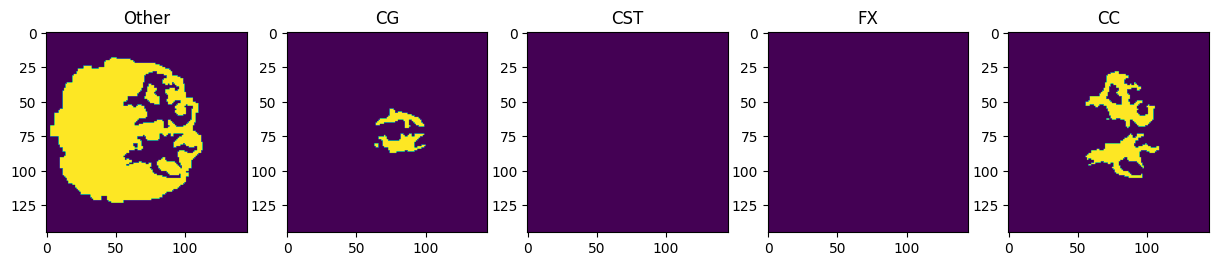

In [35]:
def plot_label(labels):
    fig, axs = plt.subplots(1, 5, figsize=(15,5))
    axs[0].imshow(labels[0,slice,:,:])
    axs[0].set_title('Other')
    axs[1].imshow(labels[1,slice,:,:])
    axs[1].set_title('CG')
    axs[2].imshow(labels[2,slice,:,:])
    axs[2].set_title('CST')
    axs[3].imshow(labels[3,slice,:,:])
    axs[3].set_title('FX')
    axs[4].imshow(labels[4,slice,:,:])
    axs[4].set_title('CC')
    plt.show()

plot_label(dataset.label)

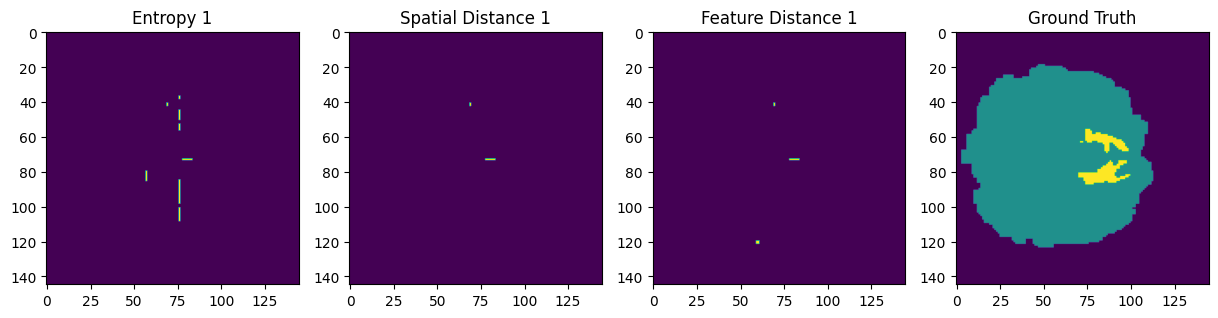

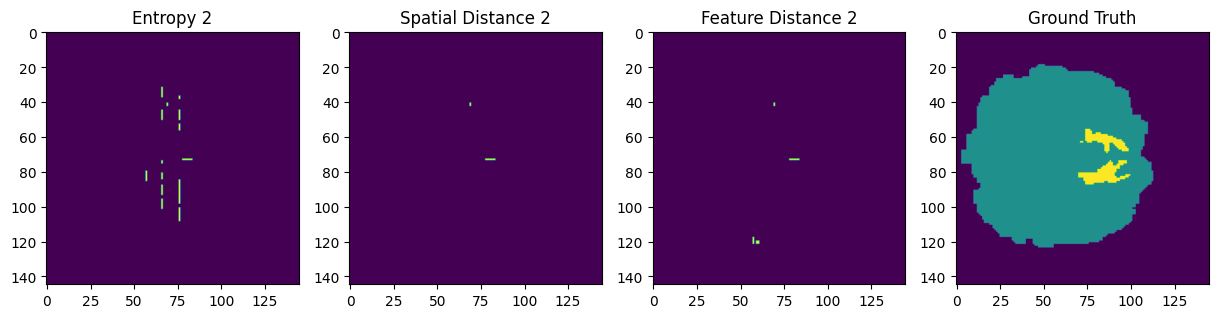

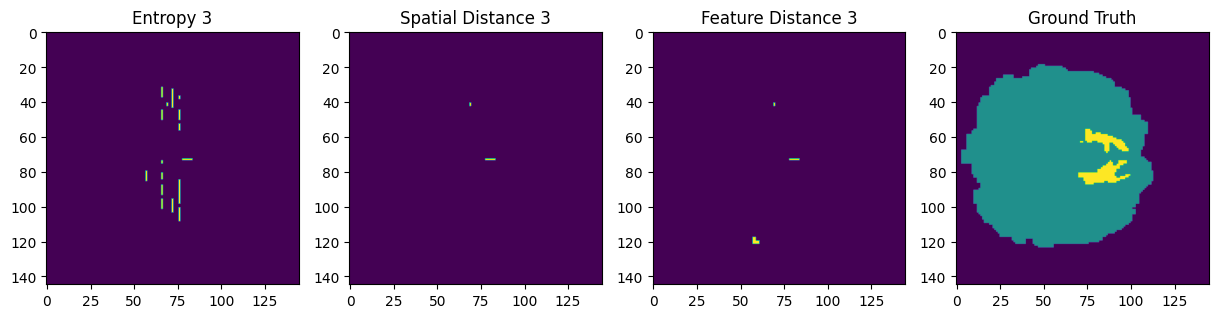

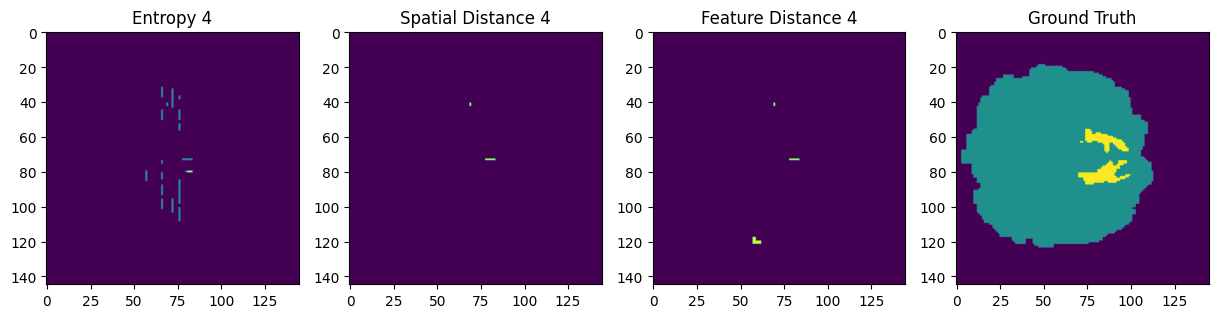

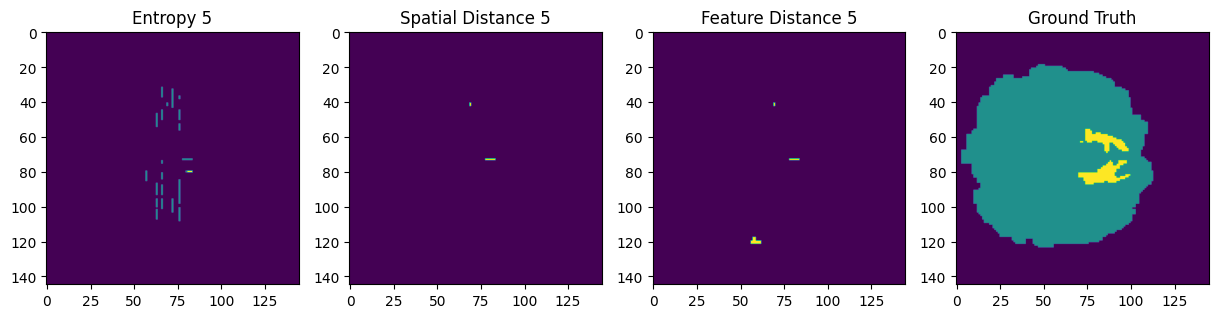

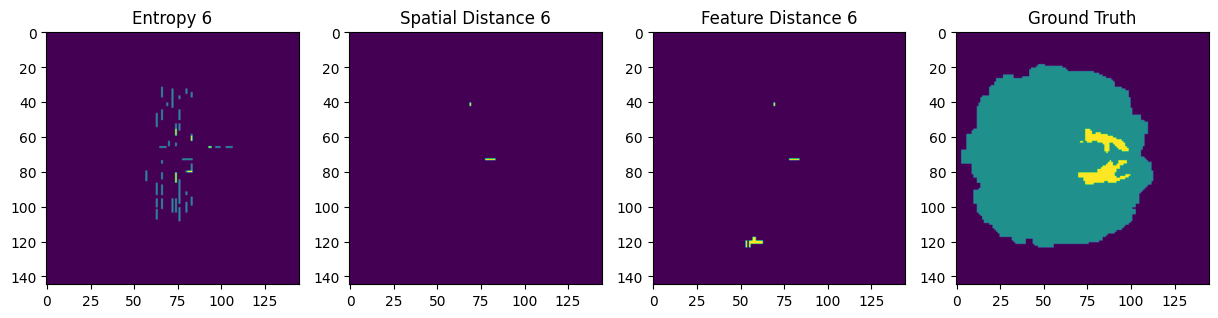

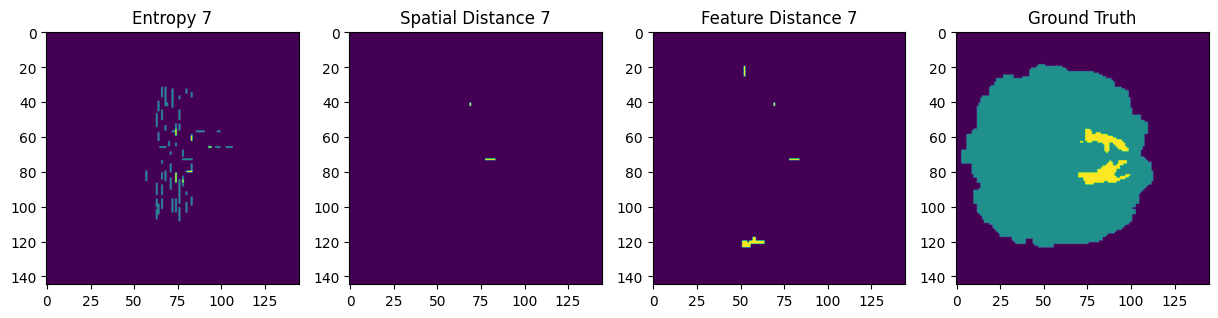

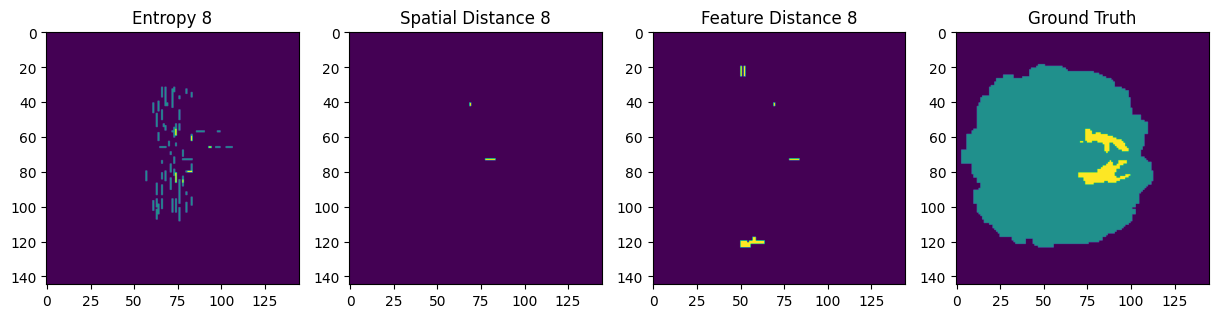

In [36]:
def plot_annots():
    for i, annot in enumerate(zip(entropy_annots, sd_annots, fd_annots)):
        fig, axs = plt.subplots(1,4, figsize=(15,5))
        axs[0].imshow(annot[0].sum(0)[slice])
        axs[0].set_title(f'Entropy {i+1}')
        axs[1].imshow(annot[1].sum(0)[slice])
        axs[1].set_title(f'Spatial Distance {i+1}')
        axs[2].imshow(annot[2].sum(0)[slice])
        axs[2].set_title(f'Feature Distance {i+1}')
        axs[3].imshow(dataset.label.sum(0)[slice])
        axs[3].set_title('Ground Truth')
        plt.show()

plot_annots()